In [2]:
import numpy as np
import sklearn
import pandas as pd
# from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 100
%matplotlib inline

In [3]:
def transform(df):
    df2 = df.copy()
    #fill na for city data - 395 missing entries - categorical and numerical, for now assume they come from the most frequent town
    df2['commune_code'] = df2['commune_code'].fillna(df2['commune_code'].mode()[0])
    df2['canton_code'] = df2['canton_code'].fillna(df2['canton_code'].mode()[0])
    df2['city_district_code'] = df2['city_district_code'].fillna(df2['city_district_code'].mode()[0])
    df2['regional_department_code'] = df2['regional_department_code'].fillna(df2['regional_department_code'].mode()[0])
    df2['population'] = df2['population'].fillna(df2['population'].mode()[0])
    df2['town_mean_altitude'] = df2['town_mean_altitude'].fillna(df2['town_mean_altitude'].mode()[0])
    df2['town_surface_area'] = df2['town_surface_area'].fillna(df2['town_surface_area'].mode()[0])
    
#     #impute or remove illogical values
    df2.loc[df2['vh_weight']==0,'vh_weight'] = df2['vh_weight'].median() # - 2959 missing entries - imputation doesnt give a better correlation
    df2 = df2.loc[df2['drv_age1']>=df2['drv_age_lic1']] # 32 missing entires; dropped
    df2 = df2.loc[df2['vh_cyl']>0] #3 missing entries
    df2.loc[df2['vh_value']==0,'vh_value'] = 18659 #from data exploration

#     #one hot encode categorical features; 
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_coverage'])],axis=1)
    df2.loc[df2['pol_usage']=='AllTrips','pol_usage'] = 'Professional' #- only 77 AllTrips; from data description it is similar to professional
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_usage'])],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_pay_freq'])],axis=1)

#     #binarize features
    df2['pol_payd'] = (df2['pol_payd'] == 'Yes') * 1 # Yes/ No
    df2['drv_drv2'] = (df2['drv_drv2'] == 'Yes') * 1 # Yes / No
    df2['tourism'] = (df2['vh_type'] == 'Tourism') * 1 #tourism or commerical
    df2['diesel'] = (df2['vh_fuel'] == 'Diesel') * 1 #also hybrids but very low representation - 62 hybrids
    df2['M'] = (df2['drv_sex1'] == 'M') * 1 #Male / Female
    
#     df2['pol_bonus2'] = (df2['pol_bonus'] == 0.5) * 1
    
    
#     #ordinally encode policy coverage
    order = {'Mini':1,'Median2':2,'Median1':3,'Maxi':4}
    df2['order_pol_coverage'] = df['pol_coverage'].apply(lambda x : order[x])

    unwantedFeatures= ['id_policy','pol_coverage','pol_pay_freq','pol_usage','pol_insee_code','drv_sex1',
                   'drv_age2','drv_sex2','drv_age_lic2','vh_fuel','vh_make','vh_model','vh_type']+['commune_code',
       'canton_code', 'city_district_code', 'regional_department_code']+['Yearly']+['made_claim','claim_amount']#+['drv_drv2']
    
    y1 = df2['made_claim']
    y2 = df2['claim_amount']
    df2 = df2.drop(unwantedFeatures,axis=1)
    return y1, y2, df2



df = pd.read_csv("training_data.csv")
y1, y2, df2 = transform(df)
df2.head()

,pol_bonus,pol_duration,pol_sit_duration,pol_payd,drv_drv2,drv_age1,drv_age_lic1,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,Maxi,Median1,Median2,Mini,Professional,Retired,WorkPrivate,Biannual,Monthly,Quarterly,tourism,diesel,M,order_pol_coverage
0,0.5,36,6,0,0,77,55,15,1598,111,16,15,185,17517,1260.0,526.0,3216.0,4.8,1,0,0,0,0,1,0,1,0,0,1,0,1,4
1,0.5,15,5,0,1,52,33,12,2184,112,12,9,180,21500,1480.0,57.0,4912.0,141.3,1,0,0,0,0,0,1,0,0,0,1,1,1,4
2,0.5,16,6,0,0,52,34,20,2496,112,32,19,130,23600,2931.0,257.0,4488.0,5.3,0,0,0,1,1,0,0,0,1,0,0,1,1,1
3,0.5,11,7,0,0,67,46,12,1149,75,14,12,170,13050,930.0,109.0,1339.0,61.2,1,0,0,0,0,0,1,1,0,0,1,0,1,4
4,0.5,16,6,0,1,60,35,23,1905,93,23,18,185,17974,1035.0,24.0,1849.0,9.7,0,0,1,0,0,0,1,1,0,0,1,1,1,2


In [4]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_auc_score,roc_curve,mean_squared_error,plot_precision_recall_curve
from sklearn.model_selection import cross_val_score,train_test_split,learning_curve


def diagnosis(y1,preds):
    ax = sns.heatmap(confusion_matrix(y1,np.round(preds)),cmap = "coolwarm", annot = True,fmt="d", linewidths = 0.5)
    ax.set_title("Confusion Matrix")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    print("MSE %f"%(mean_squared_error(y1,preds)))
    print("F1 Score: %f"%(f1_score(y1,np.round(preds))))
    print(classification_report(y1,np.round(preds)))
    
def plot_learning_curve(train_sizes,train_scores,test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    fig, axes = plt.subplots(figsize=(20,3))

    axes.set_title("Learning Curve")
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
    axes.legend(loc="best")

# Model

Fit classifier with an ensemble method

Fit a regressor with ensemble method, adding the output of the priro model

Hyperparameters:
1. Feature Set
2. Training Size
3. n_estimators, max_depth

In [5]:
booleanFeatures = ['pol_payd','Professional','WorkPrivate','M','diesel','order_pol_coverage','tourism','pol_bonus2','drv_drv2']#+['Retired','Maxi', 'Median1', 'Median2', 'Mini'] # omitted - + ['drv_drv2','vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly','Quarterly']
numericFeatures = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1','town_mean_altitude'] #+ ['order_pol_coverage','town_surface_area','town_mean_altitude']
X4 = df2[numericFeatures+booleanFeatures].copy()

KeyError: "['pol_bonus2'] not in index"

# Gradient Boosting

In [ ]:
df2.corrwith(y1,method='spearman').abs().sort_values(ascending=False)

In [6]:
booleanFeatures1 = ['pol_payd','Professional','WorkPrivate','M','order_pol_coverage','drv_drv2','diesel']#+['diesel','tourism','pol_bonus2',Retired','Maxi', 'Median1', 'Median2', 'Mini'] # omitted - + ['drv_drv2','vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly','Quarterly']
numericFeatures1 = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin',  'vh_cyl','vh_sale_end','vh_age', 'vh_speed', 'drv_age1', 'vh_weight','town_mean_altitude'] #['drv_age_lic1','order_pol_coverage','town_surface_area','town_mean_altitude']
X4 = df2[numericFeatures1+booleanFeatures1].copy()

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,ExtraTreesClassifier


X_train, X_test,y_train,y_test = train_test_split(X4,y1,test_size=0.5,stratify=y1,shuffle=True)



sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 1
sample_weights[y_train == 1] = 8

gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=6,
    n_iter_no_change=100,
    max_features='auto',
    subsample=1,
    validation_fraction=0.2)
gbc
# F1 Score: 0.201124 test;  F1 Score: 0.344405 - train, F1 Score: 0.258580 total;  test_size=0.6
#MSE 0.174667,  0.159218, 0.168487

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=100, presort='deprecated',
                           random_state=None, subsample=1, tol=0.0001,
                           validation_fraction=0.2, verbose=0,
                           warm_start=False)

MSE 0.174594
F1 Score: 0.201209
              precision    recall  f1-score   support

           0       0.92      0.76      0.84     36063
           1       0.14      0.38      0.20      3630

    accuracy                           0.73     39693
   macro avg       0.53      0.57      0.52     39693
weighted avg       0.85      0.73      0.78     39693



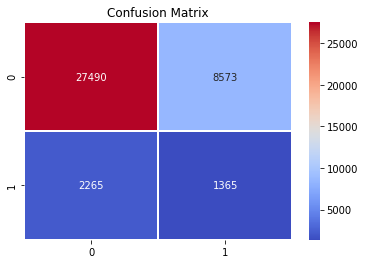

In [8]:
gbc.fit(X_train,y_train,sample_weight=sample_weights)
preds = gbc.predict_proba(X_test)[:,1]
diagnosis(y_test,preds)

In [ ]:
preds = gbc.predict_proba(X_train)[:,1]
diagnosis(y_train,preds)

In [ ]:
diagnosis(y1,gbc.predict_proba(X4)[:,1])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
rfFeatImportances = dict(sorted(zip(list(X4.columns),gbc.feature_importances_),key=lambda k: k[1]))
plt.barh(list(rfFeatImportances.keys()),rfFeatImportances.values())

In [ ]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(20,10))
plot_tree(gbc.estimators_[0][0])

## ExtraTrees

In [ ]:
hgbc = ExtraTreesClassifier(n_estimators=500,max_depth=8,class_weight={0:1,1:9})
#0.21742582553173864 - 3 fold CV
#Test - 0.216443; Train -  0.239785; Total - 0.225755
scores = cross_val_score(hgbc,X4,y1,cv=3,scoring='f1')
print(scores.mean())


In [ ]:
hgbc.fit(X_train,y_train)
preds = hgbc.predict(X_test)
diagnosis(y_test,preds)

In [ ]:
diagnosis(y_train,hgbc.predict(X_train))

In [ ]:
diagnosis(y1,hgbc.predict(X4))

In [ ]:
train_sizes,train_scores,test_scores = learning_curve(hgbc,X_train,y_train,train_sizes=[0.2,0.3,0.4,0.5,0.7,0.8],cv=3,scoring='f1',n_jobs=-1)
plot_learning_curve(train_sizes,train_scores,test_scores)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
rfFeatImportances = dict(sorted(zip(list(X4.columns),hgbc.feature_importances_),key=lambda k: k[1]))
plt.barh(list(rfFeatImportances.keys()),rfFeatImportances.values())

## RandomForest

In [ ]:

rf = RandomForestClassifier(n_estimators=500,
                            class_weight={0:0.1,1:0.9},
                            max_depth=8,
                           max_features='auto',
                           min_samples_split=2,
                           min_samples_leaf=1)
# rfFeatures = ['town_mean_altitude', 'Retired', 'town_surface_area', 'tourism', 'WorkPrivate', 'M', 'pol_duration', 'Median1', 'Professional', 'population', 'Median2', 'pol_bonus', 'diesel', 'vh_cyl', 'vh_weight', 'vh_speed', 'vh_din', 'vh_value', 'Mini', 'Maxi', 'order_pol_coverage', 'vh_age', 'vh_sale_end', 'vh_sale_begin']

scores = cross_val_score(rf,X4,y1,scoring='f1',cv=3)
print(scores.mean())
#0.21819232888690412 - 3 Fold CV
#0.217587 Test_size = 0.6;  0.268735 - Train; 0.238009 overall

In [ ]:
rf.fit(X_train,y_train)
preds = rf.predict(X_test)
diagnosis(y_test,preds)

In [ ]:
diagnosis(y_train,rf.predict(X_train))


In [ ]:
preds = rf.predict_proba(X4)[:,1]
diagnosis(y1,preds)

In [ ]:
train_sizes,train_scores,test_scores = learning_curve(rf,X_train,y_train,train_sizes=[0.2,0.4,0.5,0.7,0.8],cv=3,scoring='f1',n_jobs=-1)
plot_learning_curve(train_sizes,train_scores,test_scores)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
rfFeatImportances = dict(sorted(zip(list(X4.columns),rf.feature_importances_),key=lambda k: k[1]))
plt.barh(list(rfFeatImportances.keys()),rfFeatImportances.values())

In [ ]:
# average_precision = average_precision_score(y_test, np.round(preds)
fig,ax = plt.subplots(figsize=(20,10))
ax.set_title('Precision-Recall curve: ')
disp = plot_precision_recall_curve(rf, X_test, y_test,ax=ax)
disp = plot_precision_recall_curve(hgbc, X_test, y_test,ax=ax)
disp = plot_precision_recall_curve(gbc, X_test, y_test,ax=ax)

## XGBoost

In [ ]:
y1.sum()/y1.shape[0]

In [ ]:
import xgboost
xgbc = xgboost.XGBClassifier(n_estimators=250,
                     max_depth=5,
                     n_jobs=-1,
                     scale_pos_weight=10,
                    verbosity=0)
scores = cross_val_score(xgbc,X4,y1,cv=3,scoring='f1')
print(scores.mean())
#CV 3 folds F1 Score - 0.21081828972419817
#Test - 0.207682, Train -0.366479
#F1 Score: 0.271086

In [ ]:
xgbc.fit(X_train,y_train)
preds = xgbc.predict(X_test)
diagnosis(y_test,preds)

In [ ]:
diagnosis(y_train,xgbc.predict(X_train))

In [ ]:
diagnosis(y1,xgbc.predict(X4))

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
disp = plot_precision_recall_curve(xgbc, X_test, y_test,ax=ax)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbc,ax=ax)

In [ ]:
X4['preds'] = gbc.predict_proba(X4)[:,1]

# GradientBoostingRegressor

In [ ]:
X4['preds'].corr(y2,method='spearman')

In [ ]:
df2.corrwith(y2,method='spearman').abs().sort_values(ascending=False)

In [ ]:
# booleanFeatures2 = ['pol_payd','Professional','M','order_pol_coverage']#+['WorkPrivate','tourism','drv_drv2','diesel','pol_bonus2']
# numericFeatures2 = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1','town_mean_altitude']
# X5 = df2[numericFeatures2+booleanFeatures2].copy()

# y3 = np.log1p(np.log1p(y2))

In [ ]:
xgbr = xgb.XGBRegressor(booster='gbtree',
                        objective='reg:squarederror',
                        n_estimators=250,
                        max_depth=3,
                        n_jobs=-1,
                       base_score=111,
                        reg_lambda=0,
                       tree_method='auto')


## reg_linear
#R2 score: test -0.36960265966819006
#R2 score: train 0.7181145853602448
#R2 score: train 0.42226508586504097

## reg tweedle
#R2 score: test 0.0011444542173265626
#R2 score: train 0.4230753652735849
#R2 score: whole 0.1081898662435753

#reg tweedle2
#R2 score: test 0.0046847270411131126
# R2 score: train 0.25352758528892305
# R2 score: whole 0.06784544045526653

#Cross val - 0.0023689254022928874 2 fold
scores = cross_val_score(xgbr,X4,y2,cv=3,n_jobs=-1,scoring='r2')
print(scores.mean())

In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X4,y2,test_size=0.5,shuffle=True)
xgbr.fit(X_train,y_train)
print("R2 score: test",r2_score(y_test,xgbr.predict(X_test)))
print("R2 score: train",r2_score(y_train,xgbr.predict(X_train)))
preds = xgbr.predict(X4)
print("R2 score: whole",r2_score(y2,preds))

fig,axes = plt.subplots()
axes.set_title('Preds vs Actual')
plt.scatter(preds,y2)

In [ ]:
fig,axes = plt.subplots()
axes.set_title('Residual plot')
plt.scatter(y2-preds,y2)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbr,ax=ax)

In [ ]:
train_sizes,train_scores,test_scores = learning_curve(xgbr,X4,y2,train_sizes=[0.2,0.3,0.5,0.7,0.8],scoring='r2',cv=3,n_jobs=-1)
plot_learning_curve(train_sizes,train_scores,test_scores)

In [ ]:
fig,ax = plt.subplots(figsize=(50,10))
xgb.plot_tree(xgbr,ax=ax)

# Gradient Boosting Regression

In [14]:
GradientBoostingRegressor?

In [9]:
X4['preds'] = gbc.predict_proba(X4)[:,1]

In [61]:
X5 = X4.copy()

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
lr = LinearRegression()
gbr = GradientBoostingRegressor(n_estimators=500,max_depth=5,loss='ls',n_iter_no_change=100)

scores = cross_val_score(gbr,X4,y2,cv=3,n_jobs=-1,scoring='r2')
print(scores.mean())

#R2 score 0.5782434142409241
#gbr = GradientBoostingRegressor(n_estimators=300,max_depth=3,loss='ls',init=lr)

-0.5268432372304209


R2 score: test -0.08110781913898757
R2 score: train 0.8845323858619275
R2 score: whole 0.628645463649084


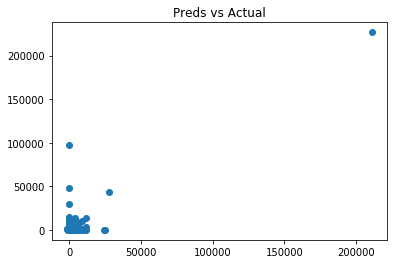

In [69]:
X_train, X_test,y_train,y_test = train_test_split(X4,y2,test_size=0.5,stratify=y1,shuffle=True)
gbr.fit(X_train,y_train)



print("R2 score: test",r2_score(y_test,gbr.predict(X_test)))
print("R2 score: train",r2_score(y_train,gbr.predict(X_train)))
preds = gbr.predict(X4)
print("R2 score: whole",r2_score(y2,preds))

fig,axes = plt.subplots()
axes.set_title('Preds vs Actual')
plt.scatter(preds,y2)

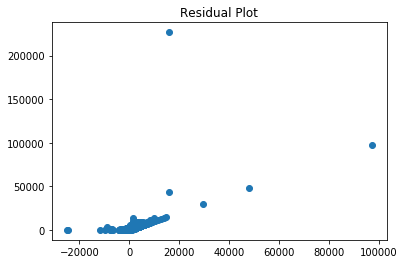

In [70]:
fig,axes = plt.subplots()
axes.set_title('Residual Plot')
plt.scatter(y2-preds,y2)

<BarContainer object of 22 artists>

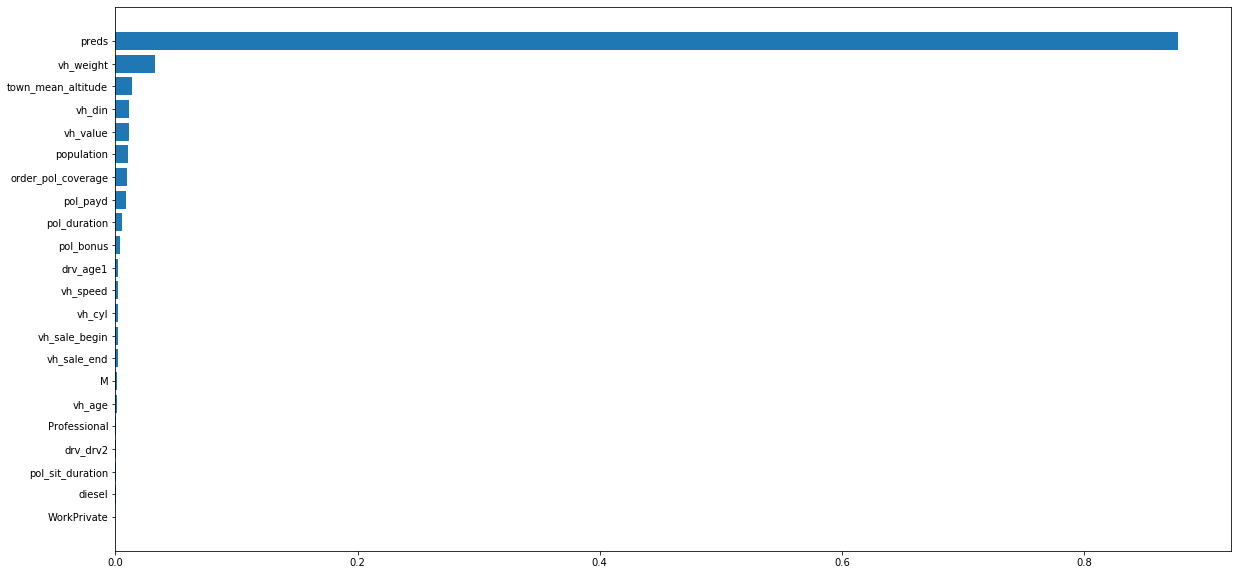

In [71]:
fig,ax = plt.subplots(figsize=(20,10))
rfFeatImportances = dict(sorted(zip(list(X4.columns),gbr.feature_importances_),key=lambda k: k[1]))
plt.barh(list(rfFeatImportances.keys()),rfFeatImportances.values())

In [ ]:
train_sizes,train_scores,test_scores = learning_curve(rfr,X5,y2,train_sizes=[0.2,0.3,0.5,0.7,0.8],scoring='r2',cv=3,n_jobs=-1)
plot_learning_curve(train_sizes,train_scores,test_scores)

R2 score 0.06054796811067431


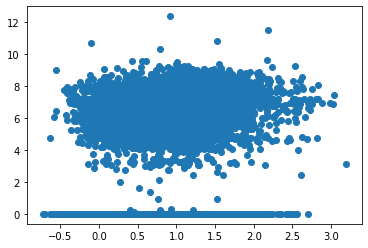

In [14]:
lr = LinearRegression()
lr.fit(X4,np.log1p(y2))
preds = lr.predict(X4)
print("R2 score",r2_score(np.log1p(y2),preds))
plt.scatter(preds,np.log1p(y2))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=300,max_depth=4,n_jobs=-1,oob_score=False,criterion='mse')

#rfr = RandomForestRegressor(n_estimators=100,max_depth=4,n_jobs=-1,oob_score=False,criterion='mse')
# R2 score: test -0.037424266969034115
# R2 score: train 0.40043381074433515
# R2 score: whole 0.06840551827537289
#CV 2 fold - -0.07774507642929063

# R2 score: test -0.030616402080559935
# R2 score: train 0.12165898061488489
# R2 score: whole 0.08189159337483476
#CV 2 fold: -0.09246238676875262
scores = cross_val_score(rfr,X4,y2,cv=2,n_jobs=-1,scoring='r2')
print(scores.mean())


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X5,y2,test_size=0.5,shuffle=True)
rfr.fit(X_train,y_train)
print("R2 score: test",r2_score(y_test,rfr.predict(X_test)))
print("R2 score: train",r2_score(y_train,rfr.predict(X_train)))
preds = rfr.predict(X5)
print("R2 score: whole",r2_score(y2,preds))

plt.scatter(preds,y2)

In [ ]:
train_sizes,train_scores,test_scores = learning_curve(rfr,X5,y2,train_sizes=[0.2,0.3,0.5,0.7,0.8],scoring='r2',cv=3,n_jobs=-1)
plot_learning_curve(train_sizes,train_scores,test_scores)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
rfFeatImportances = dict(sorted(zip(list(X5.columns),rfr.feature_importances_),key=lambda k: k[1]))
plt.barh(list(rfFeatImportances.keys()),rfFeatImportances.values())

In [ ]:
df2.corrwith(y2,method='spearman').abs().sort_values(ascending=False)

In [ ]:
#https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow
#https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis
#https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
#https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now#Logistic-regression-classifier---Skewed-data
#https://www.kaggle.com/nschneider/gbm-vs-xgboost-vs-lightgbm
#https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail
#https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve#Credit-Card-Fraud:-Handling-highly-imbalance-classes-and-why-Receiver-Operating-Characteristics-Curve-(ROC-Curve)-should-not-be-used,-and-Precision/Recall-curve-should-be-preferred-in-highly-imbalanced-situations
#Tobit
#validation_curve
#https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

#Survival Analysis, Cox model

#Gamma distribution, tweedie

#https://www.ibm.com/support/knowledgecenter/en/SS3RA7_17.0.0/spss/tutorials/genlin_car-ins_intro.html
#https://arxiv.org/pdf/1711.08695.pdf

#https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44608

#https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44558

#https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629

#https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/42197

#https://arxiv.org/pdf/1904.10890.pdf

#https://nycdatascience.com/blog/student-works/predicting-insurance-claim-severity/

#https://nycdatascience.com/blog/student-works/predicting-insurance-claim-severity/

#https://www.kaggle.com/c/ClaimPredictionChallenge/discussion?sortBy=active&group=all&page=1&pageSize=20&category=all

In [ ]:
from scipy import stats
sns.distplot(np.log(y2[y2>0]),fit=stats.norm)

In [ ]:
pip install lightgbm